# 07-Finance Tutorial-Pricing Asian Barrier Spreads

In [ ]:
#this example is at:
# https://qiskit-community.github.io/qiskit-finance/tutorials/07_asian_barrier_spread_pricing.html

In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister, transpile
from qiskit.circuit.library import IntegerComparator, WeightedAdder, LinearAmplitudeFunction
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
#from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

from quantumrings.toolkit.qiskit import QrSamplerV1 as Sampler

In [2]:
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension)

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=(list(zip(low, high))))

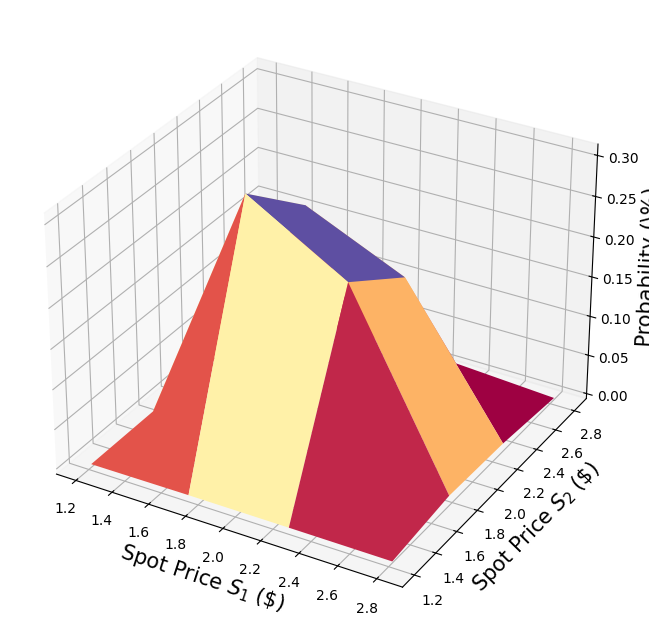

In [3]:
# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_1$ (\$)", size=15)
ax.set_ylabel("Spot Price $S_2$ (\$)", size=15)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

In [4]:
# determine number of qubits required to represent total loss
weights = []
for n in num_qubits:
    for i in range(n):
        weights += [2**i]

# create aggregation circuit
agg = WeightedAdder(sum(num_qubits), weights)
n_s = agg.num_sum_qubits
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # number of additional qubits

In [5]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 3
strike_price_2 = 4

# set the barrier threshold
barrier = 2.5

# map strike prices and barrier threshold from [low, high] to {0, ..., 2^n-1}
max_value = 2**n_s - 1
low_ = low[0]
high_ = high[0]

mapped_strike_price_1 = (
    (strike_price_1 - dimension * low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
)
mapped_strike_price_2 = (
    (strike_price_2 - dimension * low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
)
mapped_barrier = (barrier - low) / (high - low) * (2**num_uncertainty_qubits - 1)

In [6]:
# condition and condition result
conditions = []
barrier_thresholds = [2] * dimension
n_aux_conditions = 0
for i in range(dimension):
    # target dimension of random distribution and corresponding condition (which is required to be True)
    comparator = IntegerComparator(num_qubits[i], mapped_barrier[i] + 1, geq=False)
    n_aux_conditions = max(n_aux_conditions, comparator.num_ancillas)
    conditions += [comparator]

In [7]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price_1, mapped_strike_price_2]
slopes = [0, 1, 0]
offsets = [0, 0, mapped_strike_price_2 - mapped_strike_price_1]
f_min = 0
f_max = mapped_strike_price_2 - mapped_strike_price_1
objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [8]:
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension)

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

In [9]:
# define overall multivariate problem
qr_state = QuantumRegister(u.num_qubits, "state")  # to load the probability distribution
qr_obj = QuantumRegister(1, "obj")  # to encode the function values
ar_sum = AncillaRegister(n_s, "sum")  # number of qubits used to encode the sum
ar_cond = AncillaRegister(len(conditions) + 1, "conditions")
ar = AncillaRegister(
    max(n_aux, n_aux_conditions, objective.num_ancillas), "work"
)  # additional qubits

objective_index = u.num_qubits

# define the circuit
asian_barrier_spread = QuantumCircuit(qr_state, qr_obj, ar_cond, ar_sum, ar)

# load the probability distribution
asian_barrier_spread.append(u, qr_state)

# apply the conditions
for i, cond in enumerate(conditions):
    state_qubits = qr_state[(num_uncertainty_qubits * i) : (num_uncertainty_qubits * (i + 1))]
    asian_barrier_spread.append(cond, state_qubits + [ar_cond[i]] + ar[: cond.num_ancillas])

# aggregate the conditions on a single qubit
asian_barrier_spread.mcx(ar_cond[:-1], ar_cond[-1])

# apply the aggregation function controlled on the condition
asian_barrier_spread.append(agg.control(), [ar_cond[-1]] + qr_state[:] + ar_sum[:] + ar[:n_aux])

# apply the payoff function
asian_barrier_spread.append(objective, ar_sum[:] + qr_obj[:] + ar[: objective.num_ancillas])

# uncompute the aggregation
asian_barrier_spread.append(
    agg.inverse().control(), [ar_cond[-1]] + qr_state[:] + ar_sum[:] + ar[:n_aux]
)

# uncompute the conditions
asian_barrier_spread.mcx(ar_cond[:-1], ar_cond[-1])

for j, cond in enumerate(reversed(conditions)):
    i = len(conditions) - j - 1
    state_qubits = qr_state[(num_uncertainty_qubits * i) : (num_uncertainty_qubits * (i + 1))]
    asian_barrier_spread.append(
        cond.inverse(), state_qubits + [ar_cond[i]] + ar[: cond.num_ancillas]
    )

print(asian_barrier_spread.draw())
print("objective qubit index", objective_index)

              ┌───────┐┌──────┐             ┌───────────┐      ┌──────────────┐»
     state_0: ┤0      ├┤0     ├─────────────┤1          ├──────┤1             ├»
              │       ││      │             │           │      │              │»
     state_1: ┤1      ├┤1     ├─────────────┤2          ├──────┤2             ├»
              │  P(X) ││      │┌──────┐     │           │      │              │»
     state_2: ┤2      ├┤      ├┤0     ├─────┤3          ├──────┤3             ├»
              │       ││      ││      │     │           │      │              │»
     state_3: ┤3      ├┤      ├┤1     ├─────┤4          ├──────┤4             ├»
              └───────┘│      ││      │     │           │┌────┐│              │»
         obj: ─────────┤      ├┤      ├─────┤           ├┤3   ├┤              ├»
                       │      ││      │     │           ││    ││              │»
conditions_0: ─────────┤2     ├┤      ├──■──┤           ├┤    ├┤              ├»
                       │  cm

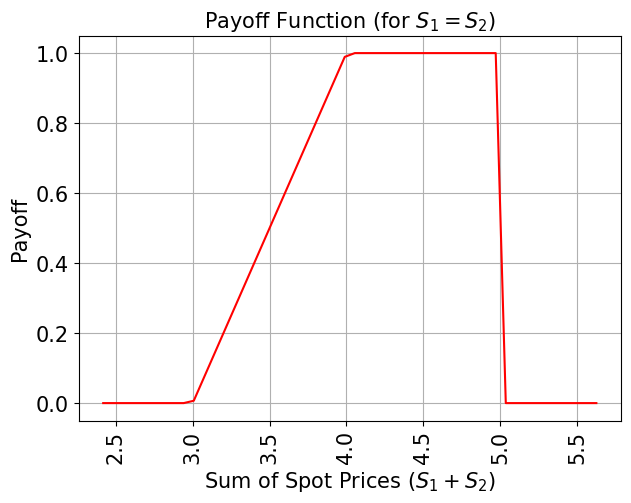

In [10]:
# plot exact payoff function
plt.figure(figsize=(7, 5))
x = np.linspace(sum(low), sum(high))
y = (x <= 5) * np.minimum(np.maximum(0, x - strike_price_1), strike_price_2 - strike_price_1)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function (for $S_1 = S_2$)", size=15)
plt.xlabel("Sum of Spot Prices ($S_1 + S_2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

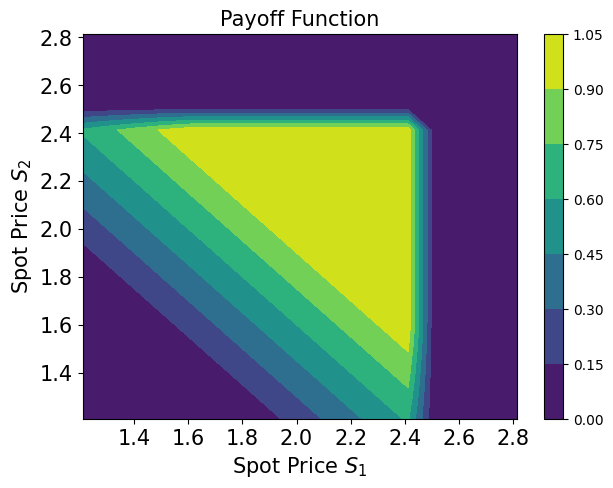

In [11]:
# plot contour of payoff function with respect to both time steps, including barrier
plt.figure(figsize=(7, 5))
z = np.zeros((17, 17))
x = np.linspace(low[0], high[0], 17)
y = np.linspace(low[1], high[1], 17)
for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        z[i, j] = np.minimum(
            np.maximum(0, x_ + y_ - strike_price_1), strike_price_2 - strike_price_1
        )
        if x_ > barrier or y_ > barrier:
            z[i, j] = 0

plt.title("Payoff Function", size=15)
plt.contourf(x, y, z)
plt.colorbar()
plt.xlabel("Spot Price $S_1$", size=15)
plt.ylabel("Spot Price $S_2$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [12]:
# evaluate exact expected value
sum_values = np.sum(u.values, axis=1)
payoff = np.minimum(np.maximum(sum_values - strike_price_1, 0), strike_price_2 - strike_price_1)
leq_barrier = [np.max(v) <= barrier for v in u.values]
exact_value = np.dot(u.probabilities[leq_barrier], payoff[leq_barrier])
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.8023


In [13]:
num_state_qubits = asian_barrier_spread.num_qubits - asian_barrier_spread.num_ancillas
print("state qubits: ", num_state_qubits)
transpiled = transpile(asian_barrier_spread, basis_gates=["u", "cx"])
print("circuit width:", transpiled.width())
print("circuit depth:", transpiled.depth())

state qubits:  5
circuit width: 14
circuit depth: 6049


In [14]:
asian_barrier_spread_measure = asian_barrier_spread.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(asian_barrier_spread_measure)

In [15]:
# evaluate the result
value = 0
probabilities = job.result().quasi_dists[0].binary_probabilities()
for i, prob in probabilities.items():
    if prob > 1e-4 and i[-num_state_qubits:][0] == "1":
        value += prob


# map value to original range
mapped_value = objective.post_processing(value) / (2**num_uncertainty_qubits - 1) * (high_ - low_)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % mapped_value)
print("Exact Expected Payoff: %.4f" % exact_value)

Exact Operator Value:  0.6318
Mapped Operator value: 0.8357
Exact Expected Payoff: 0.8023


In [16]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=asian_barrier_spread,
    objective_qubits=[objective_index],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})
)


In [17]:
result = ae.estimate(problem)

In [18]:
conf_int = (
    np.array(result.confidence_interval_processed)
    / (2**num_uncertainty_qubits - 1)
    * (high_ - low_)
)
print("Exact value:    \t%.4f" % exact_value)
print(
    "Estimated value:\t%.4f"
    % (result.estimation_processed / (2**num_uncertainty_qubits - 1) * (high_ - low_))
)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.8023
Estimated value:	0.8283
Confidence interval: 	[0.8202, 0.8363]
